In [12]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# The first part of the data preprocessing is adapted from 
# https://github.com/florian-huber/weather_prediction_dataset
def find_startline(filename, string_to_search):
    with open(filename, 'r') as read_obj:
        # Read all lines in the file one by one
        for i, line in enumerate(read_obj):
            # For each line, check if line contains the string
            if string_to_search in line:
                return i
        return False
    
year_span = 10
year_start = 2010
date_low = int(str(year_start) + "0101")  #20050101
date_high = int(str(year_start + year_span) + "0101") #20150101
print(f"Collect from {date_low} until {date_high}")

path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "data")
data_path = os.path.join(path_data, "ECAD_DATA")
data_path = os.path.join(data_path, "DUSSELDORF")
# data_path = "data\\ECAD_DATA\\DUSSELDORF"
data_collection = {}


feature_types = {"TG_": "temp_mean",
                 "TN_": "temp_min",
                 "TX_": "temp_max",
                 "SS_": "sunshine",
                 "CC_": "cloud_cover",
                 "FG_": "wind_speed",
                 "FX_": "wind_gust",
                 "HU_": "humidity",
                 "PP_": "pressure",
                 "QQ_": "global_radiation",
                 "RR_": "precipitation",
                 "SS_": "sunshine"}

#data_collection[folder] = {}
for file in os.listdir(data_path):
    if file[:3] in feature_types.keys():
        header_line = find_startline(os.path.join(data_path, file), "SOUID,")
        if header_line:
            df = pd.read_csv(os.path.join(data_path, file), header=header_line,
                            skip_blank_lines=False)
            df.columns = [x.strip() for x in df.columns]
            df_select = df[(df["DATE"] >= date_low) & (df["DATE"] <= date_high)]
            # Add column values to collection
            # Add date
            data_collection["DATE"] = df_select["DATE"].values
            data_collection["MONTH"] = [int(str(x)[4:6]) for x in df_select["DATE"].values]
            data_collection[feature_types[file[:3]]] = df_select[file[:2]].values
            
dataset = pd.DataFrame.from_dict(data_collection)
dataset.head

Collect from 20100101 until 20200101


<bound method NDFrame.head of           DATE  MONTH  cloud_cover  wind_speed  wind_gust  humidity  pressure  \
0     20100101      1            8          39         82        89      9997   
1     20100102      1            7          36         88        88     10152   
2     20100103      1            8          30         77        92     10205   
3     20100104      1            7          27         82        88     10180   
4     20100105      1            7          36         72        87     10076   
...        ...    ...          ...         ...        ...       ...       ...   
3648  20191228     12            6          31         91        84     -9999   
3649  20191229     12            6          51        118        67     -9999   
3650  20191230     12            3          53        113        50     -9999   
3651  20191231     12            5          17         63        87     -9999   
3652  20200101      1            1          40        106        86     -9999  

In [13]:
# clean up the data
# if invalid fraction is greater than 5%, drop it
drop_columns = []
for column in dataset.columns:
    invalid_values = np.sum(dataset[column].values == -9999)
    percentage_invalid = 100 * invalid_values/(year_span*365.25)
    if percentage_invalid > 1:
        print(column, f"invalid fraction: {percentage_invalid:.3f}")    
    if percentage_invalid > 5:
        print("--> drop column,", column)
        drop_columns.append(column)
dataset = dataset.drop(columns=drop_columns)

# replace -9999 value with the mean of all other valid values
for column in dataset.columns:
    idx = np.where(dataset[column].values == -9999)[0]
    if idx.shape[0] > 0:
        mean_value = dataset[column][dataset[column] != -9999].mean()
        print(f"Replace {idx.shape[0]} -9999 values in {column} by mean of {mean_value}")
        dataset[column].values[idx] = dataset[column][dataset[column] != -9999].mean()

# Normalize the data to a smaller range
for column in dataset.columns:
    if "humidity" in column:
        dataset[column] = dataset[column] / 100
    elif "pressure" in column:
        dataset[column] = dataset[column] / 10000
    elif "temp" in column:
        dataset[column] = dataset[column] / 10
    elif "sunshine" in column:
        dataset[column] = dataset[column] / 10
    elif "wind_speed" in column:
        dataset[column] = dataset[column] / 10
    elif "wind_gust" in column:
        dataset[column] = dataset[column] / 10
    elif "global_radiation" in column:
        dataset[column] = dataset[column] / 100
    elif "precipitation" in column:
        dataset[column] = dataset[column] / 100

# dataset.to_csv("data\\preprocessed_weather_dataset.csv", index=False)

dataset.head

pressure invalid fraction: 19.028
--> drop column, pressure
global_radiation invalid fraction: 9.172
--> drop column, global_radiation
Replace 1 -9999 values in wind_speed by mean of 39.458926615553125
Replace 2 -9999 values in wind_gust by mean of 106.67515749109833
Replace 2 -9999 values in humidity by mean of 75.18214187893727


<bound method NDFrame.head of           DATE  MONTH  cloud_cover  wind_speed  wind_gust  humidity  \
0     20100101      1            8         3.9        8.2      0.89   
1     20100102      1            7         3.6        8.8      0.88   
2     20100103      1            8         3.0        7.7      0.92   
3     20100104      1            7         2.7        8.2      0.88   
4     20100105      1            7         3.6        7.2      0.87   
...        ...    ...          ...         ...        ...       ...   
3648  20191228     12            6         3.1        9.1      0.84   
3649  20191229     12            6         5.1       11.8      0.67   
3650  20191230     12            3         5.3       11.3      0.50   
3651  20191231     12            5         1.7        6.3      0.87   
3652  20200101      1            1         4.0       10.6      0.86   

      precipitation  sunshine  temp_mean  temp_min  temp_max  
0              0.02       0.0       -1.1      -2.8    

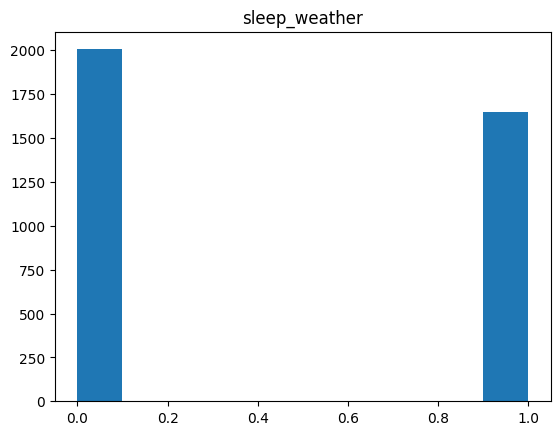

In [14]:
# Create sleep day label for the dataset
sleep_weather = {}
sleep_weather["DATE"] = dataset["DATE"].values


cloud_cover = None
temp_max = None
for x in dataset.columns:
    if "cloud_cover" in x:
        cloud_cover = dataset[x].values
    elif "temp_max" in x:
        temp_max = dataset[x].values
        
    if cloud_cover is not None and temp_max is not None:
        sleep_weather["sleep_weather"] = ((cloud_cover > 5) & (temp_max <= 20))
        break

labels_sleep = pd.DataFrame.from_dict(sleep_weather)
# labels_sleep.to_csv("data\\weather_prediction_sleep_labels.csv", index=False)

key = "sleep_weather"
plt.hist(sleep_weather[key].astype(int))
plt.title(key)
plt.show()

In [15]:
# For the real dataset, drop cloud_cover and temp_max because we
# used them for label generation
dataset.drop(["cloud_cover", "temp_max"], axis=1, inplace=True)

# Manual feature engineering:
# Create a comfort index integrating temp_mean and humidity
def gaussian(x, mu, sigma):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

# assume the comfort score follows gaussian distribution, closer to optimal point, larger the score.
def comfort_score(temp_mean, humidity, optimal_temp, temp_sigma, optimal_humidity, humidity_sigma):
    temp_score = gaussian(temp_mean, optimal_temp, temp_sigma)
    humidity_score = gaussian(humidity, optimal_humidity, humidity_sigma)
    # Combine the temperature and humidity scores
    combined_score = (temp_score + humidity_score) / 2
    return combined_score

optimal_temp = 18
optimal_humidity = 0.6
temp_sigma = dataset['temp_mean'].std()
humidity_sigma = dataset['humidity'].std()
dataset['comfort_score'] = dataset.apply(lambda row: comfort_score(row['temp_mean'], row['humidity'], optimal_temp, temp_sigma, optimal_humidity, humidity_sigma), axis=1)
# dataset = dataset.merge(labels_sleep, on='DATE', how='left')
# dataset.to_csv("data\\weather_dataset.csv", index=False)
dataset.head

<bound method NDFrame.head of           DATE  MONTH  wind_speed  wind_gust  humidity  precipitation  \
0     20100101      1         3.9        8.2      0.89           0.02   
1     20100102      1         3.6        8.8      0.88           0.45   
2     20100103      1         3.0        7.7      0.92           0.00   
3     20100104      1         2.7        8.2      0.88           0.01   
4     20100105      1         3.6        7.2      0.87           0.00   
...        ...    ...         ...        ...       ...            ...   
3648  20191228     12         3.1        9.1      0.84           0.00   
3649  20191229     12         5.1       11.8      0.67           0.00   
3650  20191230     12         5.3       11.3      0.50           0.00   
3651  20191231     12         1.7        6.3      0.87           0.01   
3652  20200101      1         4.0       10.6      0.86           0.00   

      sunshine  temp_mean  temp_min  comfort_score  
0          0.0       -1.1      -2.8     